<a href="https://colab.research.google.com/github/emarkou/multilingual-bert-text-classification/blob/master/mBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install transformers

In [1]:
import time
import numpy as np
import pandas as pd

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertPreTrainedModel, BertModel
from transformers import get_linear_schedule_with_warmup

2024-05-04 13:39:39.476557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 13:39:39.476643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 13:39:39.581253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU in use:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

GPU in use: Tesla T4


In [4]:
MAX_LEN = 128 # max sequences length
batch_size = 32

In [5]:
# extra preprocessing steps
# prepend CLS and append SEP, truncate, pad

labels_encoding = {"neg":0,"pos":2,"neutral":1}

def preprocessing(df):
    sentences = df.review.values
    labels = np.array([labels_encoding[l] for l in df.sentiment.values])

    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

    encoded_sentences = []
    for sent in sentences:
        encoded_sent = tokenizer.encode(
                            sent,
                            add_special_tokens = True,
                            truncation=True,
                            max_length = MAX_LEN
                    )

        encoded_sentences.append(encoded_sent)
    encoded_sentences = pad_sequences(encoded_sentences, maxlen=MAX_LEN, dtype="long",
                            value=0, truncating="post", padding="post")
    return encoded_sentences, labels

def attention_masks(encoded_sentences):
    # attention masks, 0 for padding, 1 for actual token
    attention_masks = []
    for sent in encoded_sentences:
        att_mask = [int(token_id > 0) for token_id in sent]
        attention_masks.append(att_mask)
    return attention_masks

In [6]:
# load the datasets
df = pd.read_csv("/kaggle/input/mtgcn-testrain/DATA_train.csv")
df_test = pd.read_csv("/kaggle/input/mtgcn-testrain/DATA_test.csv")
df=df.dropna()
df_test=df_test.dropna()

In [7]:
df.head()


,review,sentiment
0,శ్రీలంకలో ఉగ్రదాడుల దృష్ట్యా అప్రమత్తంగా ఉండాల...,neutral
1,"ఒక్కొక్కరిని‌ 20 లక్షలు అడిగారని, సుపుత్రుడి ద...",neg
2,ఈయన గారికి కూడా తెలంగాణపై చాలా ఆశలు వున్నాయి,neutral
3,బాలికలకు రూ:2250 నుంచి రూ 3000లకు పెంచారు.\n,neutral
4,ఆయా శాఖ అధికారులతో తక్షణమే నివేదిక తెప్పించుకొ...,pos


In [8]:
print(df.columns)


Index(['review', 'sentiment'], dtype='object')


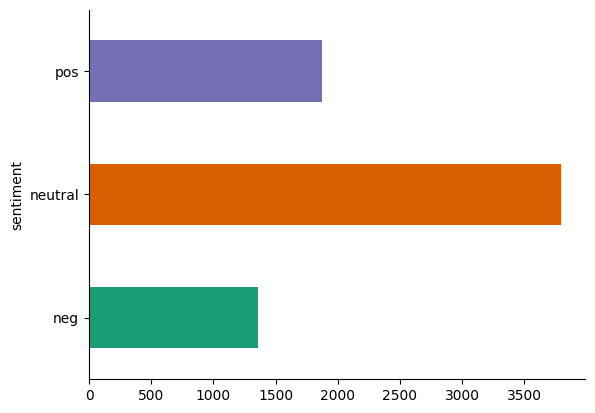

In [9]:
# @title target

from matplotlib import pyplot as plt
import seaborn as sns
df_test.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [10]:
train_encoded_sentences, train_labels = preprocessing(df)
train_attention_masks = attention_masks(train_encoded_sentences)

test_encoded_sentences, test_labels = preprocessing(df_test)
test_attention_masks = attention_masks(test_encoded_sentences)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [11]:
train_inputs = torch.tensor(train_encoded_sentences)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_attention_masks)

validation_inputs = torch.tensor(test_encoded_sentences)
validation_labels = torch.tensor(test_labels)
validation_masks = torch.tensor(test_attention_masks)

In [12]:
# data loader for training
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# data loader for validation
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [13]:

import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

optimizer = AdamW(model.parameters(),
                  lr = 3e-5,
                  eps = 1e-8,
                  weight_decay = 0.01
                )

epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # 10% * datasetSize/batchSize
                                            num_training_steps = total_steps)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
import numpy as np
import torch
import time
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_accuracy(preds, labels):
    p = np.argmax(preds, axis=1).flatten()
    l = labels.flatten()
    return np.sum(p == l) / len(l)

def run_train(epochs):
    losses = []
    for e in range(epochs):
        print('======== Epoch {:} / {:} ========'.format(e + 1, epochs))
        start_train_time = time.time()
        total_loss = 0
        model.train()
        for step, batch in enumerate(train_dataloader):

            if step % 10 == 0:
                elapsed = time.time() - start_train_time
                print(f'{step}/{len(train_dataloader)} --> Time elapsed {elapsed}')

            input_data = batch[0].to(device)
            input_masks = batch[1].to(device)
            input_labels = batch[2].to(device)

            model.zero_grad()

            out = model(input_data,
                        token_type_ids=None,
                        attention_mask=input_masks,
                        labels=input_labels)

            loss = out[0]
            total_loss = total_loss + loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

            optimizer.step()

        epoch_loss = total_loss / len(train_dataloader)
        losses.append(epoch_loss)
        print(f"Training took {time.time() - start_train_time}")

        # Validation
        start_validation_time = time.time()
        model.eval()
        eval_loss, eval_acc = 0, 0
        y_true, y_pred = [], []
        for step, batch in enumerate(validation_dataloader):
            batch = tuple(t.to(device) for t in batch)
            eval_data, eval_masks, eval_labels = batch
            with torch.no_grad():
                out = model(eval_data,
                            token_type_ids=None,
                            attention_mask=eval_masks)
            logits = out[0].detach().cpu().numpy()
            labels = eval_labels.cpu().numpy()
            batch_acc = compute_accuracy(logits, labels)
            eval_acc += batch_acc

            # Append true and predicted labels for computing F1, precision, and recall
            y_true.extend(labels)
            y_pred.extend(np.argmax(logits, axis=1))

        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        print(f"Accuracy: {eval_acc / (step + 1)}, Time elapsed: {time.time() - start_validation_time}")
        print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
    return losses

# Run training
epochs = 5  # or any number of epochs you want
losses = run_train(epochs)


======== Epoch 1 / 5 ========
0/879 --> Time elapsed 0.008123159408569336
10/879 --> Time elapsed 7.287259578704834
20/879 --> Time elapsed 13.657437801361084
30/879 --> Time elapsed 20.116305112838745
40/879 --> Time elapsed 26.643263339996338
50/879 --> Time elapsed 33.27226495742798
60/879 --> Time elapsed 39.925814390182495
70/879 --> Time elapsed 46.65265941619873
80/879 --> Time elapsed 53.46653747558594
90/879 --> Time elapsed 60.39981245994568
100/879 --> Time elapsed 67.42897963523865
110/879 --> Time elapsed 74.50389242172241
120/879 --> Time elapsed 81.52036643028259
130/879 --> Time elapsed 88.45204377174377
140/879 --> Time elapsed 95.30205464363098
150/879 --> Time elapsed 102.12567210197449
160/879 --> Time elapsed 108.94312691688538
170/879 --> Time elapsed 115.74456334114075
180/879 --> Time elapsed 122.5476245880127
190/879 --> Time elapsed 129.38627409934998
200/879 --> Time elapsed 136.25714588165283
210/879 --> Time elapsed 143.14910221099854
220/879 --> Time elaps

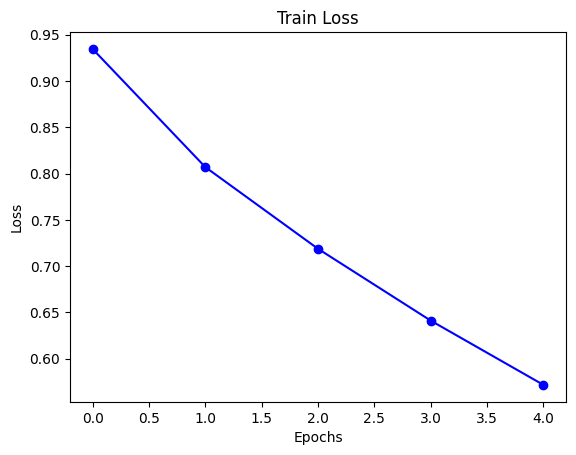

In [15]:
 # plot losses
import matplotlib.pyplot as plt
# % matplotlib inline

import seaborn as sns

plt.plot(losses, 'b-o')
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [16]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [17]:
def run_test(df_test):

    test_encoded_sentences, test_labels = preprocessing(df_test)
    test_attention_masks = attention_masks(test_encoded_sentences)

    test_inputs = torch.tensor(test_encoded_sentences)
    test_labels = torch.tensor(test_labels)
    test_masks = torch.tensor(test_attention_masks)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    model.eval()
    eval_loss, eval_acc = 0,0
    for step, batch in enumerate(test_dataloader):
        batch = tuple(t.to(device) for t in batch)
        eval_data, eval_masks, eval_labels = batch
        with torch.no_grad():
            out = model(eval_data,
                        token_type_ids = None,
                        attention_mask=eval_masks)
        logits = out[0]
        logits = logits.detach().cpu().numpy()
        eval_labels = eval_labels.to('cpu').numpy()
        batch_acc = compute_accuracy(logits, eval_labels)
        eval_acc += batch_acc
    print(f"Accuracy: {eval_acc/(step+1)}")

In [18]:
run_test(df_test)

Accuracy: 0.6506087662337663
